<a href="https://colab.research.google.com/github/ZulfaliaPutri/Capstone_WebsiteSentimenTwitter/blob/main/Binary_Label_with_Sklearn_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sources :**

https://www.megabagus.id/machine-learning-natural-language-processing/3/

https://www.kaggle.com/lbronchal/sentiment-analysis-with-svm

**Import Library**

In [107]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Load Data**

In [108]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [109]:
df = pd.read_csv('/content/gdrive/My Drive/Capstone/dataset/data_clean.csv')
df.head()

,Unnamed: 0,Tweet,HS,Abusive
0,0,cowok usaha lacak perhati gue lantas remeh per...,1,1
1,1,rt guna guna telat tau edan sarap gue gaul cig...,0,1
2,2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0
3,3,guna guna ku tau mata sipit,0,0
4,4,guna guna kaum cebong kafir dongok dungu haha,1,1


**Menggabungkan label Hate Speech dan Abusive**

In [110]:
df['HS_Abusive'] = np.where((df['HS'] == 1) | (df['Abusive'] == 1), 1, 0)
df

,Unnamed: 0,Tweet,HS,Abusive,HS_Abusive
0,0,cowok usaha lacak perhati gue lantas remeh per...,1,1,1
1,1,rt guna guna telat tau edan sarap gue gaul cig...,0,1,1
2,2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0,0
3,3,guna guna ku tau mata sipit,0,0,0
4,4,guna guna kaum cebong kafir dongok dungu haha,1,1,1
...,...,...,...,...,...
13164,13164,guna bicara ndasmu congor sekata anjing,1,1,1
13165,13165,guna kasur enak kunyuk,0,1,1
13166,13166,guna hati hati bisu bosan duh x98,0,0,0
13167,13167,guna guna guna guna bom real mudah deteksi bom...,0,0,0


**Menghapus kolom yang tidak diperlukan**

In [111]:
df = df.drop(columns=["Unnamed: 0","HS","Abusive"])
df

,Tweet,HS_Abusive
0,cowok usaha lacak perhati gue lantas remeh per...,1
1,rt guna guna telat tau edan sarap gue gaul cig...,1
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0
3,guna guna ku tau mata sipit,0
4,guna guna kaum cebong kafir dongok dungu haha,1
...,...,...
13164,guna bicara ndasmu congor sekata anjing,1
13165,guna kasur enak kunyuk,1
13166,guna hati hati bisu bosan duh x98,0
13167,guna guna guna guna bom real mudah deteksi bom...,0


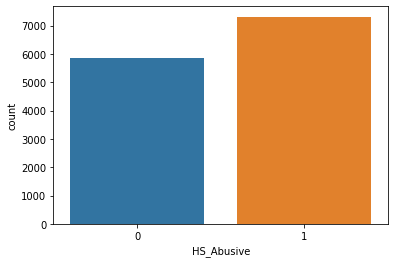

In [112]:
sns.countplot(x='HS_Abusive', data=df)

In [113]:
df.isnull().sum()

Tweet         6
HS_Abusive    0
dtype: int64

**Menghapus baris yang memiliki nilai null**

In [114]:
df = df.dropna()
df

,Tweet,HS_Abusive
0,cowok usaha lacak perhati gue lantas remeh per...,1
1,rt guna guna telat tau edan sarap gue gaul cig...,1
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0
3,guna guna ku tau mata sipit,0
4,guna guna kaum cebong kafir dongok dungu haha,1
...,...,...
13164,guna bicara ndasmu congor sekata anjing,1
13165,guna kasur enak kunyuk,1
13166,guna hati hati bisu bosan duh x98,0
13167,guna guna guna guna bom real mudah deteksi bom...,0


In [115]:
df.isnull().sum()

Tweet         0
HS_Abusive    0
dtype: int64

**Mendefinisikan nilai X dan y**

In [116]:
X = df['Tweet'].values
X

array(['cowok usaha lacak perhati gue lantas remeh perhati gue kasih khusus basic cowok bego',
       'rt guna guna telat tau edan sarap gue gaul cigax jifla cal licew',
       '41 kadang pikir percaya tuhan jatuh kali kali kadang tuhan tinggal orang tua rencana pisah kakak pilih kristen anak ter',
       ..., 'guna hati hati bisu bosan duh x98',
       'guna guna guna guna bom real mudah deteksi bom kubur dahsyat ledak revolusi jiwa',
       'guna situ foto ya kutil onta'], dtype=object)

In [117]:
def tokenize(text): 
    tokenizer = TweetTokenizer()
    return tokenizer.tokenize(text)

def stem(data):
    return (stemmer.stem(w) for w in analyzer(data))

ind_stopwords = set(stopwords.words("indonesian")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = ind_stopwords)

In [118]:
y = df["HS_Abusive"].values

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

**Modelling with SVC**

In [120]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.926492207490114

In [121]:
grid_svm.best_params_

{'svc__C': 0.1}

In [122]:
grid_svm.best_score_

0.9277373677354481

In [123]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [124]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.8587162932016711,
 'auc': 0.9264951151430565,
 'f1': 0.8683651804670913,
 'precision': 0.8808327351040919,
 'recall': 0.8562456385205862}

**Modelling with Logistic Regression**

In [125]:
from sklearn.linear_model import LogisticRegression
pipeline_lr = make_pipeline(vectorizer, 
                            LogisticRegression(random_state = 0))
pipeline_lr.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test) 

print('Test accuracy is : {}'.format(accuracy_score(y_test, y_pred_lr)))
print('Confusion Matrix :')
confusionmatrix_lr = confusion_matrix(y_test, y_pred_lr)
confusionmatrix_lr

Test accuracy is : 0.846942650968477
Confusion Matrix :


array([[ 990,  210],
       [ 193, 1240]])

**Modelling with KNN**

In [126]:
from sklearn.neighbors import KNeighborsClassifier
pipeline_knn = make_pipeline(vectorizer, 
                             KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))
pipeline_knn.fit(X_train, y_train)

y_pred_knn = pipeline_knn.predict(X_test) 

print('Test accuracy is : {}'.format(accuracy_score(y_test, y_pred_knn)))
print('Confusion Matrix :')
confusionmatrix_knn = confusion_matrix(y_test, y_pred_knn)
confusionmatrix_knn

Test accuracy is : 0.7246486897075579
Confusion Matrix :


array([[ 897,  303],
       [ 422, 1011]])

**Modelling with Decision Tree**

In [127]:
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = make_pipeline(vectorizer, 
                            DecisionTreeClassifier(criterion = 'entropy', random_state = 0))
pipeline_dt.fit(X_train, y_train)

y_pred_dt = pipeline_dt.predict(X_test) 

print('Test accuracy is : {}'.format(accuracy_score(y_test, y_pred_dt)))
print('Confusion Matrix :')
confusionmatrix_dt = confusion_matrix(y_test, y_pred_dt)
confusionmatrix_dt

Test accuracy is : 0.8271933156095709
Confusion Matrix :


array([[ 980,  220],
       [ 235, 1198]])

**Modelling with Random Forest**

In [128]:
# Metode Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = make_pipeline(vectorizer, 
                            RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0))
pipeline_rf.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test) 

print('Test accuracy is : {}'.format(accuracy_score(y_test, y_pred_rf)))
print('Confusion Matrix :')
confusionmatrix_rf = confusion_matrix(y_test, y_pred_rf)
confusionmatrix_rf

Test accuracy is : 0.8628940372199012
Confusion Matrix :


array([[1027,  173],
       [ 188, 1245]])